In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sys import exit
from osgeo import gdal,gdalconst
import matplotlib.pyplot as plt
from numba import njit
from numba import jit
import os
import xarray
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 20, 12

In [2]:
#BORDERS
countries=["United States of America","Spain"]

def get_borders(country):
    borders=gdal.Open("./data/national_grids/gpw_v4_national_identifier_grid_rev11_30_min.tif").ReadAsArray()
    reference=pd.read_excel("./data/national_grids/gpw-v4-documentation-rev11/gpw-v4-country-level-summary-rev11.xlsx",
                            sheet_name="GPWv4 Rev11 Summary",skiprows=1)
    reference=reference.loc[reference.iloc[:,0]==country,"ISO Numeric"].values[0]
    return (borders==reference).astype("int8")



In [3]:
#Population version: 

###
# isimip2b.input_secondary.population.ssp2soc.population.yearly
# Description: Population data set prepared for ISIMIP2b. Data Set Details: https://www.isimip.org/gett..., ISIMIP Terms of Use: https://www.isimip.org/prot..., Published under CC BY 4.0 licence.
# Data Node: esg.pik-potsdam.de
# Version: 20200716
# http://esg.pik-potsdam.de/thredds/fileServer/isimip_dataroot_2/isimip2b/input_secondary/population/ssp2soc/population/yearly/v20200716/population_ssp2soc_0p5deg_annual_2006-2100.nc
##

def get_population(year):
    
    if (year<2006)|(year>2100):
        print("Year out of range. Only the period 2006-2100 is available")
        exit
    else:
        return gdal.Open("./data/population/population_ssp2soc_0p5deg_annual_2006-2100.nc").ReadAsArray()[(year-2006),:,:]

In [4]:
un_translate={"Czech Republic":"Czechia",
                 'United Kingdom of Great Britain and Northern Ireland':"United Kingdom",
             "Cape Verde":"Cabo Verde",
             "Micronesia (Federated States of)":"Micronesia (Fed. States of)",
             "The former Yugoslav Republic of Macedonia":"North Macedonia",
             "Democratic People's Republic of Korea":"Dem. People's Republic of Korea",
             "Taiwan":"China, Taiwan Province of China","Western Samoa":"Samoa"
}
    
def get_proportions(country,year=2015):
    if year==2016:
        year=2015
    if year<=2020:
        un=pd.read_excel("./data/population/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx",sheet_name="ESTIMATES",
                        skiprows=16)
    else:
        un=pd.read_excel("./data/population/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx",sheet_name="HIGH VARIANT",
                        skiprows=16)
    un=un[un["Reference date (as of 1 July)"]==year]

    
    if country in un_translate.keys():
        country=un_translate[country]
    
    df=un[un["Region, subregion, country or area *"]==country]
    
    df["95+"]=df["95-99"]+df["100+"]
    df.drop(["95-99","100+"],axis=1,inplace=True)
    df=df.iloc[:,8:] #Getting ages
    df=df.iloc[0,:]/df.sum(axis=1).values #Calculating proportions
    return df.values    

In [5]:
gbd_translate={"Iran":"Iran (Islamic Republic of)",
                  "The Gambia":"Gambia","Cote d'Ivoire":"Côte d'Ivoire","Tanzania":"United Republic of Tanzania",
                  "Moldova":"Republic of Moldova","Vietnam":"Viet Nam","Brunei":"Brunei Darussalam",
                  "The Bahamas":"Bahamas","South Korea":"Republic of Korea",
                  "Venezuela":"Venezuela (Bolivarian Republic of)","Syria":"Syrian Arab Republic",
                  "Laos":"Lao People's Democratic Republic","Bolivia":"Bolivia (Plurinational State of)",
               "United States":"United States of America",
              "Palestine":"State of Palestine",
              "United Kingdom":"United Kingdom of Great Britain and Northern Ireland",
               "Virgin Islands, U.S.":"United States Virgin Islands",
               "Federated States of Micronesia":"Micronesia (Federated States of)",
               "Macedonia":"The former Yugoslav Republic of Macedonia",
               "North Korea":"Democratic People's Republic of Korea",
               "Taiwan (Province of China)":"Taiwan",
               "Samoa":"Western Samoa"
               
              }
gbd_translate= {v: k for k, v in gbd_translate.items()}

causes_rr=["LRI","COPD","IHD","STROKE","LC","ALL"]


def get_mort(country,year):
    ind={"LC":"LC_ALL_RISKS_MORT","IHD":"IHD_ALL_RISKS_MORT_AGEGR","STROKE":"STROKE_ALL_RISKS_MORT_AGEGR",
    "LRI":"LRI_ALL_RISKS_MORT","COPD":"COPD_ALL_RISKS_MORT"}
    results={}
    if country in gbd_translate.keys():
        country=gbd_translate[country]
    for cause in causes_rr[:-1]:
        rita_file=pd.read_excel("./data/GBD_data/MORTALITY_RATES_COUNTRIES_PROJ_GBD2017_6COD.xlsx",sheet_name=ind[cause])
        if (year==2010)|(year==2016):
            rita_file=rita_file[(rita_file.location_name==country)&(rita_file.year==2015)]
        elif year==2050:
            rita_file=rita_file[(rita_file.location_name==country)&(rita_file.year==2040)]
        else:
            rita_file=rita_file[(rita_file.location_name==country)&(rita_file.year==year)]
        results[cause]=rita_file.val.values
        
    return results    
get_mort("United States of America",2016)

{'LRI': array([27.84745996]),
 'COPD': array([50.81945422]),
 'IHD': array([2.29439798e+00, 5.18871831e+00, 1.03150228e+01, 2.01022951e+01,
        3.82387801e+01, 7.31424524e+01, 1.20868477e+02, 1.82900921e+02,
        2.56995614e+02, 4.02985929e+02, 6.60646711e+02, 1.17942551e+03,
        2.23573298e+03, 4.17560391e+03, 8.79766142e+03]),
 'STROKE': array([1.25193327e+00, 2.26276794e+00, 3.80088348e+00, 6.40453667e+00,
        1.03871426e+01, 1.80309267e+01, 2.86589932e+01, 4.37472038e+01,
        6.68164031e+01, 1.20270048e+02, 2.25870068e+02, 4.39699235e+02,
        8.33266084e+02, 1.47290654e+03, 2.72464442e+03]),
 'LC': array([55.5583539])}

In [6]:
def get_coefficients(cause_rr):
    rr=pd.read_csv("./data/GBD_data/RR_PARAMS_GBD2018.csv",sep=",")
    cause=rr[rr["COD"]==cause_rr]
    return cause["alpha_med"].values,cause["beta_med"].values,cause["delta_med"].values,cause["zcf_med"].values

@njit
def get_rr_array(alpha,beta,delta,zcf,conc_array,cause):
    a=conc_array.shape[0]
    b=conc_array.shape[1]
    c=len(alpha)
    rr_array=np.ones((c,a,b))
    for k in range(c):
        for i in range(a):
            for j in range(b):
                if conc_array[i,j]>zcf[k]:    
                    rr_array[k,i,j]=1+(alpha[k]*(1-np.exp(-beta[k]*(conc_array[i,j]-zcf[k])**delta[k])))               
    return rr_array
    
    
#@njit
def process_array(population_array,conc_array,proportions,mort_rate,cause,rr_array):

    results=conc_array*0.

    for i in range(population_array.shape[0]):
        for j in range(population_array.shape[1]):
            if (population_array[i,j]==0.):
                results[i,j]=0.
            else:
                if cause in ["IHD","STROKE"]:
                    atr_mortality=mort_rate[-15:]*(rr_array[:,i,j]-1)
                    mort=np.dot(population_array[i,j]*proportions[-15:]/100000,atr_mortality)

                else:

                    atr_mortality=mort_rate*(rr_array[:,i,j]-1)
                    mort=population_array[i,j]*atr_mortality/100000
                results[i,j]=mort
                
    return results

@njit
def population_weighted_conc(population_array,conc_array):
    results=0.
    pop=0
    for i in range(population_array.shape[0]):
        for j in range(population_array.shape[1]):
            if (conc_array[i,j]>=0) & (population_array[i,j]>0):
                results+=(population_array[i,j]*conc_array[i,j])
                pop+=population_array[i,j]
    return results/pop




## MARIANNE PM25 AND SALT FROM AMAP

In [18]:


salt=xarray.open_dataset("./data/model_layers/pm25_sea_salt_dust_amap.nc")
print(salt)



<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    pm25     (lat, lon) float32 ...
Attributes:
    comment:       contact: knut.vonsalzen@canada.ca
    data_licence:  1) GRANT OF LICENCE - The Government of Canada (Environmen...


In [9]:
model_dir="./data/model_layers/corrected/"

year=2016
scenario=""
model=salt["pm25"].data

files=sorted([x for x in os.listdir(model_dir) if (str(year) in x)&(scenario in x)&("speciated" not in x)])

files

['OsloCTM3_pm25_surfaceconc_annual_2016_ECLv6_PM25.nc',
 'OsloCTM3_pm25_surfaceconc_annual_2016_ECLv6_PM25.nc.aux.xml']

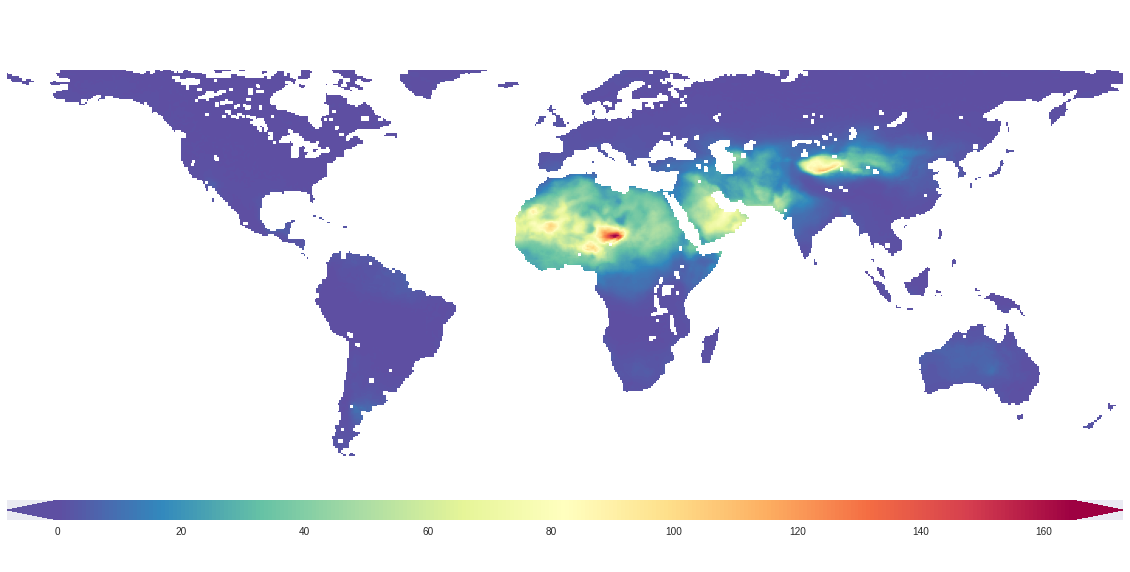

In [10]:
plt.subplots(figsize=(20,12))
plt.imshow(np.flipud(model),cmap="Spectral_r")
plt.axis("off")
plt.colorbar(extend="both",orientation="horizontal",aspect=50,pad=-0.1)


Estimation using AMAP salt layer

In [7]:
def save_raster(array,raster_template,output_name,fill=False):

    ds = gdal.Open(raster_template)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    [cols, rows] = arr.shape

    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(output_name, rows, cols, 1, gdal.GDT_Float32)
    outdata.GetRasterBand(1).SetNoDataValue(-9999)
    outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
    outdata.SetProjection(ds.GetProjection())##sets same projection as input
    outdata.GetRasterBand(1).WriteArray(array)
    if fill:
        result = gdal.FillNodata(targetBand =outdata.GetRasterBand(1), maskBand = None, 
                     maxSearchDist = 50, smoothingIterations = 2)

    outdata.FlushCache() ##saves to disk!!
    outdata = None
    band=None
    ds=None

In [8]:

#scenarios=[""]
#years=[2010]



def get_conc_array(year=2015,scenario="CLE"):
    amapdir="/home/gaia/Documents/AMAP/repo/data/Model_data/PM25/downscaled/"
    salt=xarray.open_dataset("./data/model_layers/pm25_sea_salt_dust_amap.nc")

    model_dir="./data/model_layers/corrected/"

    model=0.*salt["pm25"].data

    files=sorted([x for x in os.listdir(model_dir) if (str(year) in x)&(scenario in x)&("xml" not in x)])
    variables=["BC","NO3","OA","POA","SO4"]
    for i in range(len(variables)):
        
        model=model+xarray.open_dataset(os.path.join(model_dir,files[i]),engine="netcdf4")[variables[i]].data
    return(np.flipud(model))

def process_all(year,scenario):
    country="China"
    #c -> country class
    
    

        
        
    #         year_band={2010:4,2030:6,2050:8}
    #         population_file="./data/SSP2_POP_GRID_0.5x0.5.tif"
    population_raster=get_borders(country)*get_population(year)
    proportions=get_proportions(country,year)

    print("Total population ",np.sum(population_raster))
    print("Done")

    mortality=get_mort(country,year)
    

    yearidx={2016:1,2030:2,2050:3}
    
    model_raster=get_conc_array(year=year,scenario=scenario)


    health_impacts={}
    age_impacts={}
    rr_arrays={}
    for cause in ["COPD","LRI","LC","IHD","STROKE"]:

        alpha,beta,delta,zcf=get_coefficients(cause)

        rr_array=get_rr_array(alpha,beta,delta,zcf,model_raster,cause)
        rr_arrays[cause]=rr_array
        health_impacts[cause]=process_array(population_raster,model_raster,proportions,
                                         mortality[cause],cause,rr_array)

   
    weighted_conc=population_weighted_conc(population_raster,model_raster)
    results=[rr_arrays,weighted_conc,health_impacts]
    
    return results


Estimation using PM25 from OsloCTM

In [9]:
get_conc_array(year=2016,scenario="")

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [10]:
_,pwc,impacts=process_all(2016,"")

<ipython-input-4-63806c324160>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["95+"]=df["95-99"]+df["100+"]
/home/gaia/anaconda3/envs/gis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Total population  1364991500.0
Done
